# Graph Neural Prompting

In [1]:
!pip install -q torch_geometric

In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as pyg
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.nn.pool import global_mean_pool

## Sample

In [3]:
# small sample graph

edge_index = torch.tensor([[0, 1, 1],
                           [1, 0, 2]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index)
# >>> Data(edge_index=[2, 4], x=[3, 1])

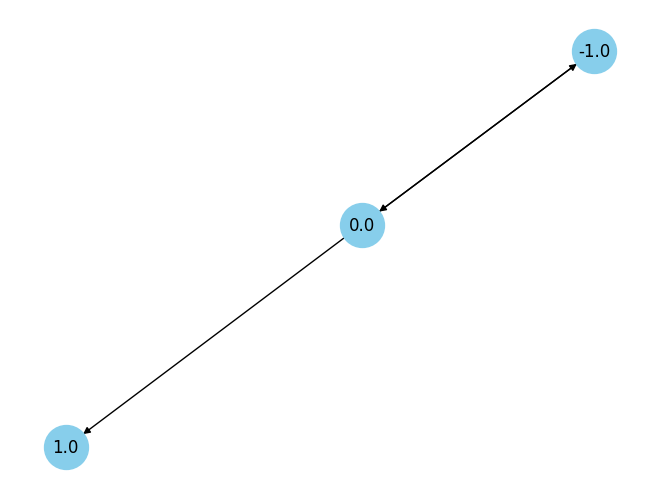

Data(x=[3, 1], edge_index=[2, 3])


In [4]:
# PyTorch GeometricデータをNetworkXグラフに変換
graph = to_networkx(data)

# 描画
pos = nx.spring_layout(graph)  # レイアウトの設定

# ノードの特徴量を取得
node_labels = {i: x[i].item() for i in range(data.num_nodes)}

# ノードの特徴量を併せて描画
nx.draw(graph, pos, with_labels=True, labels=node_labels, node_color='skyblue', node_size=1000)

plt.show()
print(data)

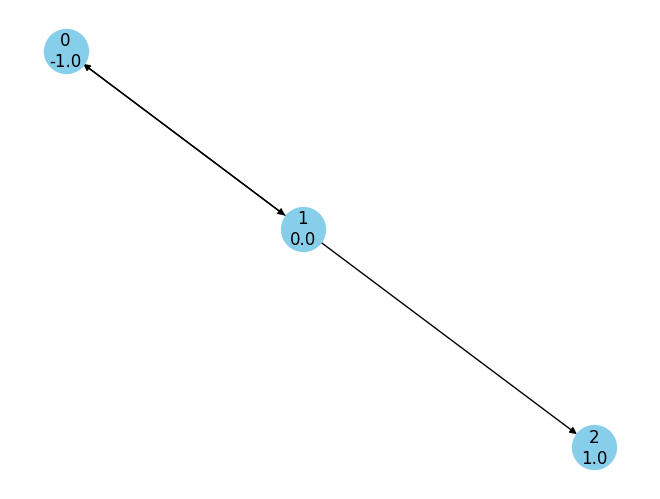

In [5]:
# PyTorch GeometricデータをNetworkXグラフに変換
graph = to_networkx(data)

# 描画
pos = nx.spring_layout(graph)  # レイアウトの設定

# ノードの特徴量を取得
node_labels = {i: (f"{i}\n{x[i].item()}" if data.x is not None else str(i)) for i in range(data.num_nodes)}

# ノードの特徴量とインデックス番号を併せて描画
nx.draw(graph, pos, with_labels=True, labels=node_labels, node_color='skyblue', node_size=1000)

plt.show()

## Subgraph Retrieval





## GNN Encoder

Data(x=[4, 8], edge_index=[2, 3])


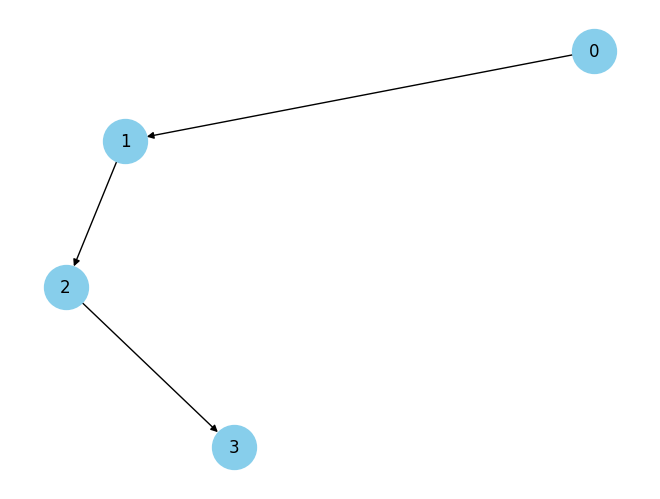

In [25]:
# sample small subgraph
edge_index = torch.tensor([[0, 1, 2],
                           [1, 2, 3]], dtype=torch.long)
x = torch.randn(4, 8)

data = Data(x=x, edge_index=edge_index)
print(data)
# PyTorch GeometricデータをNetworkXグラフに変換
graph = to_networkx(data)

# 描画
pos = nx.spring_layout(graph)  # レイアウトの設定

# ノードの特徴量を取得
# node_labels = {i: (f"{i}\n{x[i].item()}" if data.x is not None else str(i)) for i in range(data.num_nodes)}

# ノードの特徴量とインデックス番号を併せて描画
nx.draw(graph, pos, with_labels=True, labels=None, node_color='skyblue', node_size=1000)

plt.show()

GNN Encoderは，
$$H_1 = f_{GNN}(\mathcal{G}')$$
と表される．Graph Attention Networkを使用している．



In [27]:
enc = GATConv(data.num_features, 32, heads=1, dropout=0.6)

In [28]:
output = enc(data.x, data.edge_index) # H_1
output = output.unsqueeze(0)

In [29]:
output.shape

torch.Size([1, 4, 32])

## Cross Modality Pooling

まず$H_1$のself attentionをとる．
$$H_2 = \text{Self-Attn}(H_1) $$

In [30]:
attention = nn.MultiheadAttention(embed_dim=32, num_heads=4)

In [31]:
h2, _ = attention(output, output, output)

In [32]:
h2.shape

torch.Size([1, 4, 32])

In [33]:
ff1 = nn.Linear(32, 32)
ff2 = nn.Linear(32, 32)
t_prime = ff1(F.gelu(ff2(torch.randn(4, 32))))

In [34]:
t_prime.shape

torch.Size([4, 32])

In [35]:
t_prime.unsqueeze_(0).shape

torch.Size([1, 4, 32])

In [36]:
cross_attention = nn.MultiheadAttention(embed_dim=32, num_heads=4)
h3, _ = cross_attention(h2, t_prime, t_prime)

In [37]:
h3.shape

torch.Size([1, 4, 32])

average poolingを行う．
$$ H_4=\text{POOL}(H_3) $$

In [38]:
h4 = global_mean_pool(h3, batch=None)
h4.shape

torch.Size([1, 32])

## Domain Projector

$$ Z=\text{FFN}_3(\sigma(\text{FFN}_4(H_4))) $$

In [39]:
ff3 = nn.Linear(32, 32)
ff4 = nn.Linear(32, 32)
z = ff3(F.gelu(ff4(h4)))
z.shape

torch.Size([1, 32])

最終的に得られた$Z$をGraph Neural Promptとして，テキストに結合．